In [0]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import scipy as sp
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import random
import src.data_retriever as intrinio
import src.pso as pso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [0]:
random.seed(42)
datefrom = dtm.datetime(2012, 1, 1)
dateto = dtm.datetime(2019, 1, 1)

In [0]:
#DOW 30
stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
# stock_names = ['AAPL']

In [0]:
stocks_filename = 'stocks.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=stocks.columns)

### Подготовка к обучению

In [0]:
train_datefrom = dtm.datetime(2017, 1, 1)
train_dateto = dtm.datetime(2018, 6, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2019, 1, 1)

In [0]:
data = stocks.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [15]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#to_normalize = ['volume_prev1', 'ebitda']
data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))
data['stock_name'] = LabelEncoder().fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

17753


In [17]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_regr = valid_data['close']
Y_valid_classify =valid_data['close'] > valid_data['open']

1605


In [18]:
ts = time.time()

model_regr = XGBRegressor(seed=42)

model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        eval_metric='mae',
        verbose=True, 
        early_stopping_rounds = 20)
    
time.time() - ts

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-mae:102.902	validation_1-mae:140.783
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:92.6242	validation_1-mae:127.982
[2]	validation_0-mae:83.3728	validation_1-mae:115.267
[3]	validation_0-mae:75.0458	validation_1-mae:104.862
[4]	validation_0-mae:67.555	validation_1-mae:94.7894
[5]	validation_0-mae:60.8237	validation_1-mae:85.8189
[6]	validation_0-mae:54.7792	validation_1-mae:77.5312
[7]	validation_0-mae:49.3465	validation_1-mae:69.9059
[8]	validation_0-mae:44.4483	validation_1-mae:62.9788
[9]	validation_0-mae:40.0786	validation_1-mae:56.9012
[10]	validation_0-mae:36.1061	validation_1-mae:51.1242
[11]	validation_0-mae:32.5835	validation_1-mae:46.2238
[12]	validation_0-mae:29.3581	validation_1-mae:41.5917
[13]	validation_0-mae:26.5155	validation_1-mae:37.6883
[14]	validation_0-mae:23.942	validation_1-mae:34.1256
[15]	validation_0-mae:21.5763	

8.161950588226318

In [19]:
ts = time.time()

model_class = XGBClassifier(seed=42)

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-auc:0.616313	validation_1-auc:0.621568
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.634158	validation_1-auc:0.627091
[2]	validation_0-auc:0.654501	validation_1-auc:0.650938
[3]	validation_0-auc:0.657012	validation_1-auc:0.643623
[4]	validation_0-auc:0.668548	validation_1-auc:0.645451
[5]	validation_0-auc:0.669738	validation_1-auc:0.652392
[6]	validation_0-auc:0.679078	validation_1-auc:0.665142
[7]	validation_0-auc:0.684699	validation_1-auc:0.668434
[8]	validation_0-auc:0.685338	validation_1-auc:0.667848
[9]	validation_0-auc:0.691118	validation_1-auc:0.673297
[10]	validation_0-auc:0.692053	validation_1-auc:0.673127
[11]	validation_0-auc:0.693563	validation_1-auc:0.67423
[12]	validation_0-auc:0.696201	validation_1-auc:0.6766
[13]	validation_0-auc:0.698538	validation_1-auc:0.679211
[14]	validation_0-auc:0.700377	validation_1-auc:0.677852
[

3.429985523223877

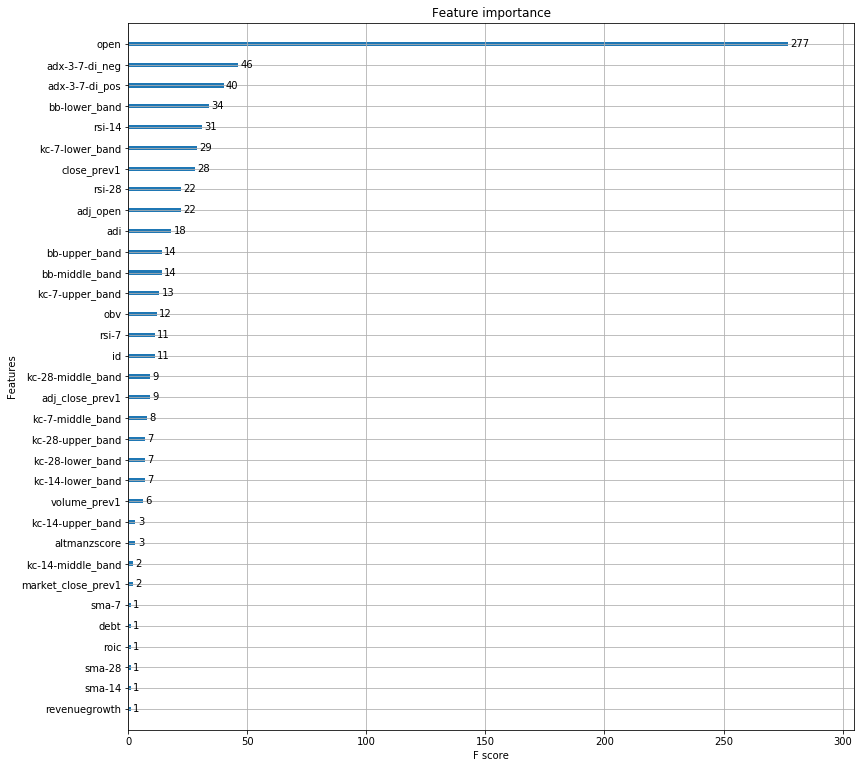

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_regr, ax=ax)

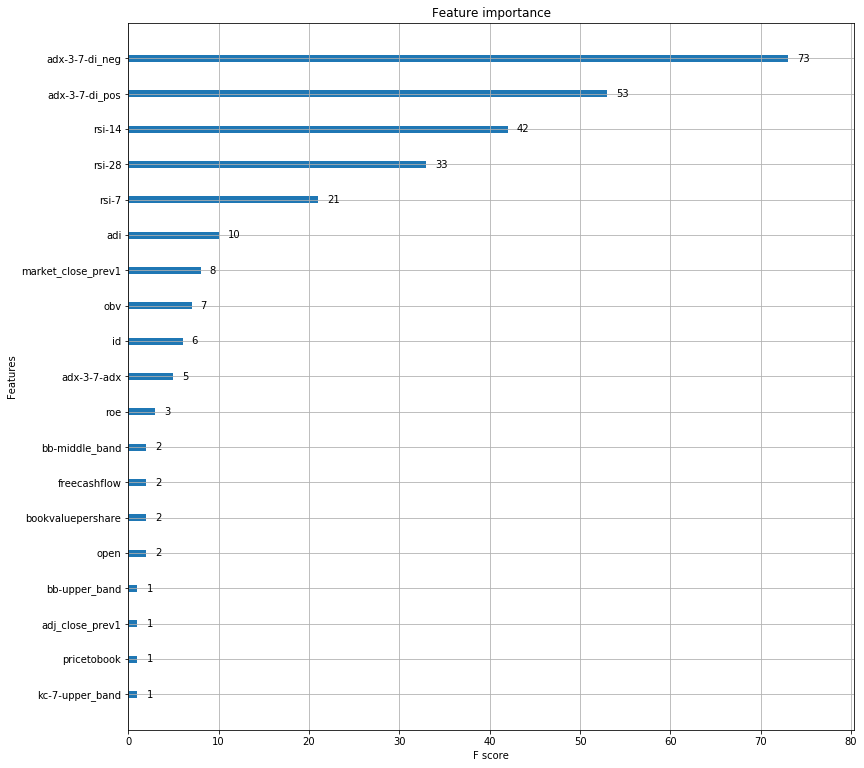

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_class, ax=ax)

In [0]:
def fitness_regr(params):
    params['seed'] = 42
    params['n_jobs'] = 4
    model_regr = XGBRegressor(**params)  

    model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)],   
        verbose=False,
        eval_metric='mae',
        early_stopping_rounds = 10)
    return model_regr.best_score

def fitness_class(params):
    params['seed'] = 42
    params['n_jobs'] = 4
    model_class = XGBClassifier(**params)  

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=False,
        eval_metric='auc',
        early_stopping_rounds = 10)
    return -model_class.best_score

patterns = [
    ("max_depth", int, 1, 50),
    ("n_estimators", int, 10, 10000),
    ("min_child_weight", int, 10, 5000),
    ("colsample_bytree", float, 0.0, 1.0),
    ("subsample", float, 0.1, 1.0),
    ("eta", float, 0.0, 1.0),
]

In [23]:
ts = time.time()
opt_class, fitness_class_res = pso.optimize(patterns, fitness_class)
time.time() - ts

n_estimators.dim_velocity = 0.0
*[1]particle.values={'max_depth': 41, 'n_estimators': 1834, 'min_child_weight': 214, 'colsample_bytree': 0.7415504997598329, 'subsample': 0.3204026684231286, 'eta': 0.1395379285251439}
n_estimators.dim_velocity = -2505.1051636621605
*[1]particle.values={'max_depth': 21, 'n_estimators': 6439, 'min_child_weight': 664, 'colsample_bytree': 0.5965191201678559, 'subsample': 0.1382903605856734, 'eta': 0.10826598189493027}
n_estimators.dim_velocity = -861.6709206635134
*[1]particle.values={'max_depth': 19, 'n_estimators': 7427, 'min_child_weight': 3409, 'colsample_bytree': 0.0877192797434631, 'subsample': 0.2823403028548622, 'eta': 0.39738454386798144}
n_estimators.dim_velocity = -2127.7796725191743
*[1]particle.values={'max_depth': 36, 'n_estimators': 4755, 'min_child_weight': 1631, 'colsample_bytree': 0.4953190475703636, 'subsample': 0.34721016825974976, 'eta': 0.5495302529925641}
n_estimators.dim_velocity = -361.70357174238495
*[1]particle.values={'max_depth'

520.0286636352539

In [32]:
opt_class, fitness_class_res

({'colsample_bytree': 0.6617438163723828,
  'eta': 0.1447537144916002,
  'max_depth': 32,
  'min_child_weight': 173,
  'n_estimators': 2725,
  'subsample': 0.31509874620111583},
 -0.71008)

In [33]:
# params_pso_class = {'colsample_bytree': 0.6617438163723828,
#   'eta': 0.1447537144916002,
#   'max_depth': 32,
#   'min_child_weight': 173,
#   'n_estimators': 2725,
#   'subsample': 0.31509874620111583,
#   'seed': 42}
model_pso_class_opt = XGBRegressor(**opt_class)
model_pso_class_opt.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=True,
        eval_metric='auc',
        early_stopping_rounds = 10)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-auc:0.635531	validation_1-auc:0.607003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670588	validation_1-auc:0.639731
[2]	validation_0-auc:0.67723	validation_1-auc:0.64372
[3]	validation_0-auc:0.689408	validation_1-auc:0.663613
[4]	validation_0-auc:0.700835	validation_1-auc:0.677352
[5]	validation_0-auc:0.705955	validation_1-auc:0.674538
[6]	validation_0-auc:0.710546	validation_1-auc:0.679287
[7]	validation_0-auc:0.715586	validation_1-auc:0.682239
[8]	validation_0-auc:0.719137	validation_1-auc:0.680012
[9]	validation_0-auc:0.722779	validation_1-auc:0.678417
[10]	validation_0-auc:0.726301	validation_1-auc:0.681185
[11]	validation_0-auc:0.730532	validation_1-auc:0.687144
[12]	validation_0-auc:0.733153	validation_1-auc:0.69302
[13]	validation_0-auc:0.736001	validation_1-auc:0.69383
[14]	validation_0-auc:0.739027	validation_1-auc:0.694521
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6617438163723828, eta=0.1447537144916002,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=32, min_child_weight=173, missing=None,
       n_estimators=2725, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.31509874620111583)

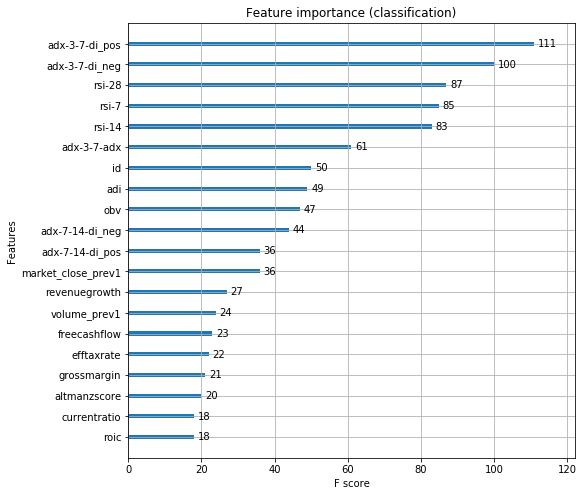

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=model_pso_class_opt, ax=ax, max_num_features=20, title='Feature importance (classification)')

In [0]:
random.seed(42)
ts = time.time()
opt_regr, fitness_regr_res = pso.optimize(patterns, fitness_regr)
time.time() - ts

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


n_estimators.dim_velocity = 0.0
*[1]particle.values={'max_depth': 41, 'n_estimators': 1834, 'min_child_weight': 214, 'colsample_bytree': 0.7415504997598329, 'subsample': 0.3204026684231286, 'eta': 0.1395379285251439}


In [0]:
opt_regr, fitness_regr_res

In [0]:
# params_pso_regr = {'colsample_bytree': 0.6160255388578953,
#   'eta': 0.2695933770248609,
#   'max_depth': 13,
#   'min_child_weight': 229,
#   'n_estimators': 4946,
#   'subsample': 0.8236539165798413,
#   'seed': 42}
model_pso_regr_opt = XGBRegressor(**opt_regr)
model_pso_regr_opt.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)],   
        verbose=False,
        eval_metric='mae',
        early_stopping_rounds = 10)

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=model_pso_regr_opt, ax=ax, max_num_features=20, title='Feature importance (regression)')

In [0]:
random.seed(42)
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
search_classif=RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, scoring="roc_auc", n_jobs=4, verbose=10)
search_classif.fit(X_train, Y_train_classify)

In [0]:
search_classif.best_estimator_

In [0]:
search_classif.best_score_

In [0]:
ts = time.time()
model_class = XGBClassifier()
model_class.set_params(**search_classif.best_estimator_.get_params())

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts

In [0]:
random.seed(42)
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
search_regr=RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist, scoring="neg_mean_absolute_error", n_jobs=4, verbose=10)
search_regr.fit(X_train, Y_train_regr)

In [0]:
search_regr.best_estimator_

In [0]:
search_regr.best_score_

In [0]:
ts = time.time()
model_regr = XGBRegressor()
model_regr.set_params(**search_regr.best_estimator_.get_params())

model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        verbose=True,         
        eval_metric='mae',
        early_stopping_rounds = 10)
print(model_regr.best_score)
    
time.time() - ts